In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

import warnings
#warnings.filterwarnings('ignore')
pd.set_option("future.no_silent_downcasting", True)

seed = 1234
np.random.seed(seed)  

In [57]:
columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
           "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
           "hours_per_week", "native_country", "income"]

# Read train data 
train_df = pd.read_csv("adult/adult.data", names=columns, sep=",", header=None)

# test data 
test_df = pd.read_csv("adult/adult.test", names=columns, sep=",", header=None, skiprows=1)

# Replace ` ?` with `NaN`
train_df.replace(' ?', np.nan, inplace=True)
test_df.replace(' ?', np.nan, inplace=True)

## EDA

In [60]:
print(train_df.shape)
train_df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
print(test_df.shape)
# test_df.head()

(16281, 15)


In [6]:
train_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
# Summary statistics for numerical columns
print(train_df.describe());

                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours_per_week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


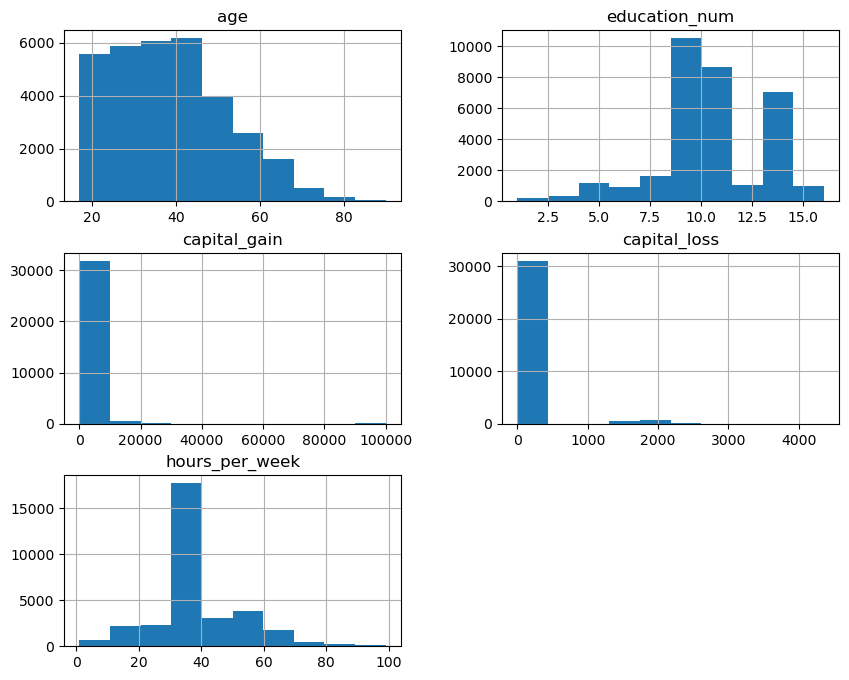

In [8]:
# Histogram
numerical_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
train_df[numerical_features].hist(figsize=(10, 8));

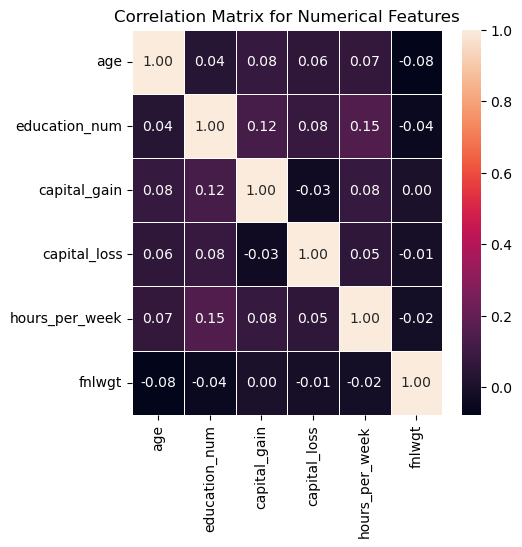

In [9]:
# CORRELATION MATRIX /HEATMAP
numerical_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', "fnlwgt"]

correlation_matrix = train_df[numerical_features].corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Numerical Features")
plt.show()

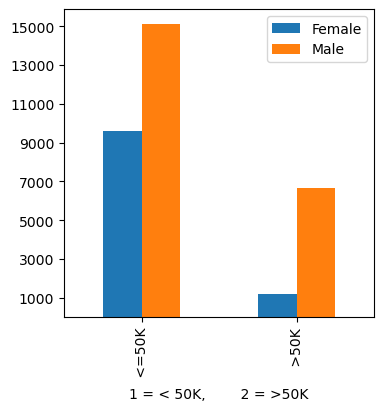

In [10]:
# income vs gender
class_sex = pd.crosstab(train_df['income'], train_df['sex'])
class_sex.plot(kind='bar', figsize=(4, 4))

plt.legend(['Female', 'Male'])
plt.xlabel('1 = < 50K,        2 = >50K')
plt.yticks(np.arange(1000,17000,2000));

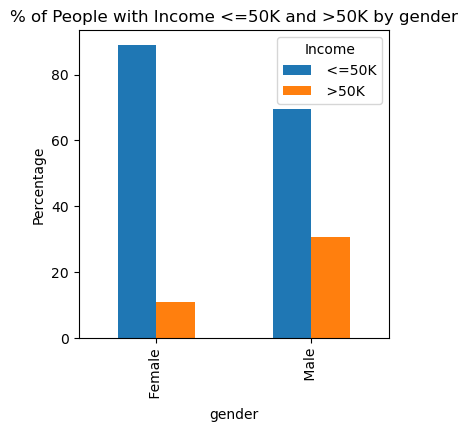

In [18]:
# Group by gender and income
gender = train_df.groupby(['sex', 'income']).size().unstack()
gender = gender.div(gender.sum(axis=1), axis=0) * 100

#gender.plot(kind='bar', stacked = True, figsize=(5, 5))
gender.plot(kind='bar',  figsize=(4, 4))

plt.title('% of People with Income <=50K and >50K by gender')
plt.xlabel('gender')
plt.ylabel('Percentage')
plt.legend(title='Income', loc='upper right');

Out of total male 30% of them earn salary more than 50K 
 while around 15% female earn more than 50K. 

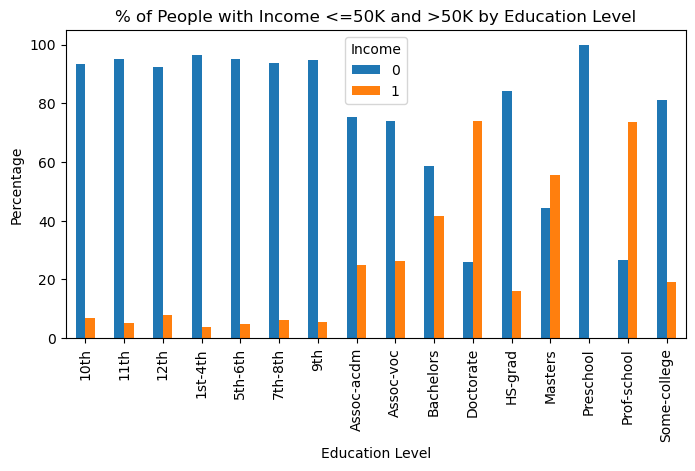

In [40]:
# Group by education and income
education = train_df.groupby(['education', 'income']).size().unstack()
education = education.div(education.sum(axis=1), axis=0) * 100

#education.plot(kind='bar', stacked=True, figsize=(8, 6))
education.plot(kind='bar', figsize=(8, 4))

plt.title('% of People with Income <=50K and >50K by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(title='Income');

# preprocessing

In [62]:
# number of missing values in train data
#print(train_df.isnull().sum())  

In [64]:
#number of missing values in test data
print(test_df.isnull().sum())  

age                 0
workclass         963
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        966
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    274
income              0
dtype: int64


In [66]:
# remove any whitespace 
train_df = train_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

# remove any whitespace 
test_df = test_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

# binary mapping for target labels
train_df['income'] = train_df['income'].map({'<=50K': 0, '>50K': 1})

# target labels of adult.test end with ".", we remove "."
test_df['income'] = test_df['income'].str.strip().str.replace('.', '')

# binary mapping for target labels
test_df['income'] = test_df['income'].map({'<=50K': 0, '>50K': 1})


education_num col is just a numerical encoding of the education column,
representing the order of education levels. 
keeping both columns might create unnecessary redundancy in the dataset.
so we drop the education col.

In [73]:
train_df = train_df.drop(columns=['education'])
test_df = test_df.drop(columns=['education'])


We decided to drop the fnlwgt column because it represents the final weight 
assigned during data collection to make the dataset representative of the population.
This column is not a meaningful predictor of an individual's income, as it reflects sampling 
adjustments rather than personal attributes. 
Including it in the analysis could introduce unnecessary noise without providing valuable 
information for the task of income prediction.

In [ ]:
train_df = train_df.drop(columns=['fnlwgt'])
test_df = test_df.drop(columns=['fnlwgt'])

In [78]:
# marital_status_mapping = {
#     'Never-married': 'Single',
#     'Married-civ-spouse': 'Married',
#     'Divorced': 'Single',
#     'Married-spouse-absent': 'Married',
#     'Separated': 'Single',
#     'Married-AF-spouse': 'Married',
#     'Widowed': 'Single'
# }

# # Replace the marital_status column based on the mapping
# train_df['marital_status'] = train_df['marital_status'].replace(marital_status_mapping)
# test_df['marital_status'] = test_df['marital_status'].replace(marital_status_mapping)

# print(train_df['marital_status'].unique())
# print(test_df['marital_status'].unique())

### Splitting train_df into train & validation sets

In [80]:
# Features
X = train_df.drop(columns=["income"])
# Target labels
y = train_df["income"]  

X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.15, random_state=seed, shuffle=True)

In [82]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)

(32561, 12)
(27676, 12)
(4885, 12)


In [86]:
X_test = test_df.drop(columns=['income'])
y_test = test_df['income']

### converting categorical data to numerical values (Encoding)

If we perform encoding before the train-test split, the model will see information from the entire dataset, including the test data, during encoding. This could lead to data leakage, where the model has prior knowledge of the test data.

In [89]:
# one hot encoder 
#https://www.geeksforgeeks.org/ml-one-hot-encoding/

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import make_column_transformer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

categorical_features =[ 'workclass',  'marital_status', 'occupation',
                        'relationship', 'race', 'sex',  'native_country']

# # Initialize the OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first') 

# # Apply the encoder to the categorical features using a ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[('cat', encoder, categorical_features)],
#     remainder='passthrough'  
# )

# # Fit and transform the training set, then transform validation and test sets
# X_train = preprocessor.fit_transform(X_train)
# X_val = preprocessor.transform(X_val)
# X_test = preprocessor.transform(X_test)


# one hot encoding w pd dummies
X_train = pd.get_dummies(X_train, columns=categorical_features)
X_val = pd.get_dummies(X_val, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)

X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [91]:
print("shapes after encoding:")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

shapes after encoding:
(27676, 87)
(4885, 87)
(16281, 87)


### handling missing values

In [98]:
# we impute the missing values in the dataset, after splitting the data. 
# This avoids data leakage.
# https://medium.com/@odil.tokhirov/how-to-deal-with-missing-and-categorical-values-in-data-used-for-machine-learning-28e8b95539bf#:~:text=So%20when%20it%20appears%20in,avoids%20something%20called%20data%20leakage.

imputer = SimpleImputer(strategy='mean') 
X_train = imputer.fit_transform(X_train)

# using the same imputer for X_val and X_test
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

### Feature scaling

In [100]:
# NO FEAUTURE SCALING REQUIRED FOR TREE BASED MODELS
# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

## Random Forest

In [104]:
# BASELINE model
learner = RandomForestClassifier(random_state=seed)
learner.fit(X_train, y_train)

# training  error rate
train_err = (y_train!= learner.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# validation error rate
val_err = (y_val!= learner.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# test error rate
test_err = (y_test!= learner.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)

#cross-validation
cv_scores = cross_val_score(learner, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")
print(f"Mean CV error: {1-cv_scores.mean()}")


Training error rate :  0.022329816447463506

validation error rate :  0.1535312180143296

test error rate :  0.15238621706283398

Cross-validation scores: [0.83544075 0.85564589 0.85781391 0.85781391 0.85022584]
Mean CV score: 0.8513880599547805
Mean CV error: 0.1486119400452195


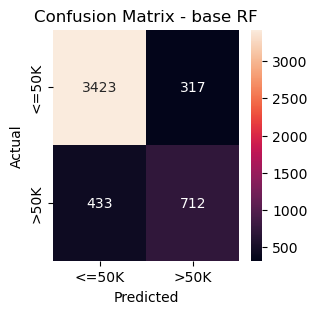


Base Model Accuracy: 0.85
Base Model Precision: 0.69
Base Model Recall: 0.62
Base Model F1-Score: 0.66


In [106]:
y_pred_val = learner.predict(X_val)

cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - base RF')
plt.show()


base_accuracy = accuracy_score(y_val, y_pred_val)
base_precision = precision_score(y_val, y_pred_val, average='binary')
base_recall = recall_score(y_val, y_pred_val, average='binary')
base_f1 = f1_score(y_val, y_pred_val, average='binary')

print(f"\nBase Model Accuracy: {base_accuracy:.2f}")
print(f"Base Model Precision: {base_precision:.2f}")
print(f"Base Model Recall: {base_recall:.2f}")
print(f"Base Model F1-Score: {base_f1:.2f}")

In [1683]:
#learner?

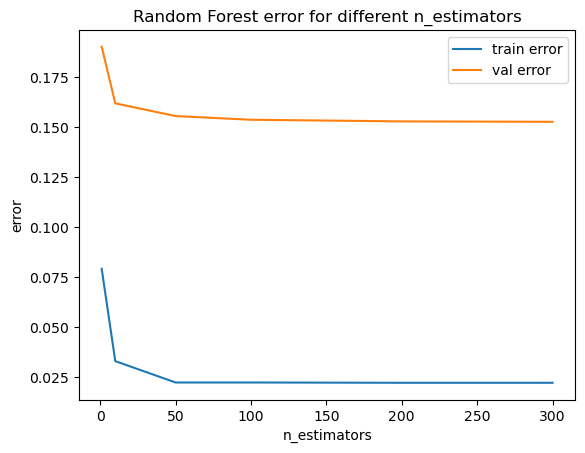

In [108]:
# number of trees to use in the ensemble
n_estimators = [1, 10, 50, 100,200,300]

train_errors = []
val_errors = []

for n in n_estimators: 

     RF = RandomForestClassifier( 
                     n_estimators=n,
                     random_state=seed)

     RF.fit(X_train, y_train)

     # Compute the training  error rates
     train_err = (y_train!= RF.predict(X_train)).mean()
     train_errors.append(train_err)

     # Compute the validation error rates
     val_err = (y_val!= RF.predict(X_val)).mean()
     val_errors.append(val_err)

# Plot the resulting performance as a function of n estimate
plt.plot(n_estimators , train_errors,  label = 'train error');
plt.plot(n_estimators , val_errors,    label = 'val error');

plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('Random Forest error for different n_estimators')
plt.legend()
plt.show()

In [1875]:
# We can see that multiple learners in an ensemble performs better than a single learner

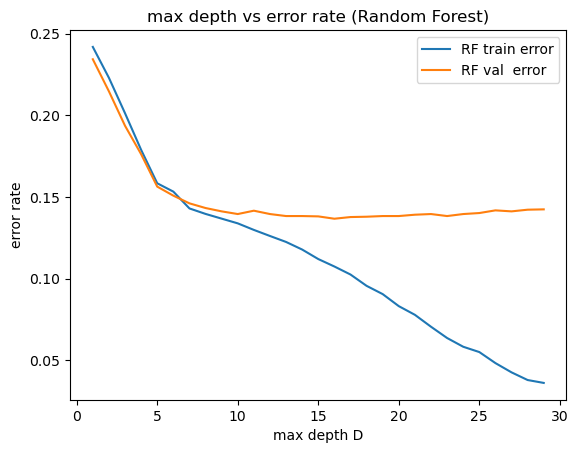

In [48]:
RF_train_err_d = []
RF_val_err_d = []

depth = list(range(1, 30))

for d in depth:
    learner = RandomForestClassifier(
    max_depth=d, 
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_d.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_d.append(val_err)

# Plot the resulting performance as a function of depth d
plt.plot(depth , RF_train_err_d,  label = 'RF train error');
plt.plot(depth , RF_val_err_d,    label = 'RF val  error');

plt.title("max depth vs error rate (Random Forest)");
plt.xlabel("max depth D");
plt.ylabel("error rate");
plt.legend();

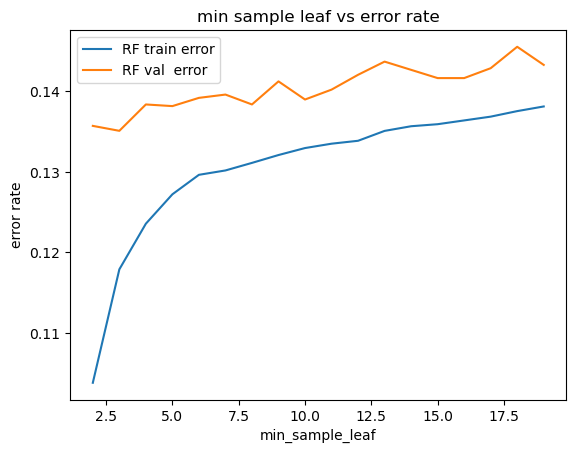

In [104]:
RF_train_err_msl = []
RF_val_err_msl = []
min_sample_leaf =  list(range(2, 20))

# creating values
# for i in range(1,6): 
#     min_sample_leaf.append(2**i)
    
for msl in min_sample_leaf: 
    
    learner = RandomForestClassifier(
    #max_depth=10,  
    min_samples_leaf=msl,  
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_msl.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_msl.append(val_err)

# Plot the resulting performance as a function of min sample leaf
plt.plot(min_sample_leaf , RF_train_err_msl,  label = 'RF train error');
plt.plot(min_sample_leaf , RF_val_err_msl,    label = 'RF val  error');
#plt.xscale('log', base=2)

plt.title("min sample leaf vs error rate");
plt.xlabel("min_sample_leaf");
plt.ylabel("error rate");
plt.legend();

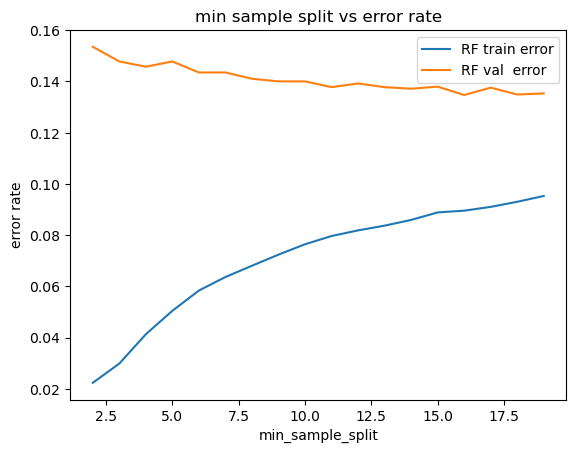

In [108]:
RF_train_err_mss = []
RF_val_err_mss = []
min_sample_split =  list(range(2, 20))
    
for mss in min_sample_split: 
    
    learner = RandomForestClassifier(
    #max_depth=10,  # Restrict depth
    min_samples_split=mss,  
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_mss.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_mss.append(val_err)

# Plot the resulting performance as a function of min sample leaf
plt.plot(min_sample_split , RF_train_err_mss,  label = 'RF train error');
plt.plot(min_sample_split , RF_val_err_mss,    label = 'RF val  error');
#plt.xscale('log', base=2)

plt.title("min sample split vs error rate");
plt.xlabel("min_sample_split");
plt.ylabel("error rate");
plt.legend();

In [110]:
train_err = []
val_err = []

max_f =  ['sqrt', 'log2', 0.25, 0.5, 0.75]

for mf in max_f:
    learner = RandomForestClassifier(
    max_features=mf,   
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    print("train err for ", mf, " : ", train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    print("val err for ", mf, " : ", val_err)

train err for  sqrt  :  0.022329816447463506
val err for  sqrt  :  0.1535312180143296
train err for  log2  :  0.022257551669316374
val err for  log2  :  0.15578300921187307
train err for  0.25  :  0.022257551669316374
val err for  0.25  :  0.14882292732855681
train err for  0.5  :  0.02222141928024281
val err for  0.5  :  0.15087001023541455
train err for  0.75  :  0.02229368405838994
val err for  0.75  :  0.15066530194472877


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
#warnings.filterwarnings('ignore')

# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [5, 10, 15, None],
#     'max_features': ['sqrt', 'log2',0.25, 0.5, 0.75],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 5],
# }

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5,10,15],
    'max_features': ['auto', 'sqrt', 'log2',  0.5]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(),
#     param_distributions=param_grid,
#     n_iter=50,  # Number of parameter settings sampled
#     cv=3,       # Number of cross-validation folds
#     random_state=seed,
#     n_jobs=-1   # Use all available cores
# )
# random_search.fit(X_train, y_train)

# print("Best parameters:", random_search.best_params_)
# print("Best score:", random_search.best_score_)

h


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pac

Best parameters: {'max_depth': 15, 'max_features': 0.5, 'n_estimators': 200}
Best score: 0.8647930928249552


In [ ]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

## optimal model

In [110]:
learner = RandomForestClassifier(random_state=seed, n_estimators = 200, max_depth = 15, max_features = 0.5)
learner.fit(X_train, y_train)

# training  error rate
train_err = (y_train!= learner.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# validation error rate
val_err = (y_val!= learner.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# test error rate
test_err = (y_test!= learner.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.09098135568723804

validation error rate :  0.13490276356192427

test error rate :  0.1334070388796757


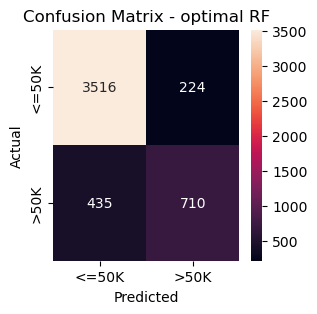


optima Model Accuracy: 0.87
optimal Model Precision: 0.76
optimal Model Recall: 0.62
optimal Model F1-Score: 0.68


In [114]:
y_pred_val = learner.predict(X_val)

cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - optimal RF')
plt.show()

optimal_accuracy = accuracy_score(y_val, y_pred_val)
optimal_precision = precision_score(y_val, y_pred_val, average='binary')
optimal_recall = recall_score(y_val, y_pred_val, average='binary')
optimal_f1 = f1_score(y_val, y_pred_val, average='binary')

print(f"\noptima Model Accuracy: {optimal_accuracy:.2f}")
print(f"optimal Model Precision: {optimal_precision:.2f}")
print(f"optimal Model Recall: {optimal_recall:.2f}")
print(f"optimal Model F1-Score: {optimal_f1:.2f}")

## Cross Validation

In [116]:
# Perform cross-validation
cv_scores = cross_val_score(learner, X_train, y_train, cv=5, scoring='accuracy') 

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")
print(f"Mean CV error: {1-cv_scores.mean()}")

Cross-validation scores: [0.84989162 0.86901536 0.86775068 0.8699187  0.86449864]
Mean CV score: 0.8642149993995124
Mean CV error: 0.1357850006004876


## Gradient Boost

Gradient boosting models generally outperform random forests
due to their ability to focus on misclassified samples

In [118]:
# https://medium.com/@24littledino/xgboost-classification-in-python-f29cc2c50a9b
import xgboost as xgb

#BASE model
xgboost= xgb.XGBClassifier(random_state=seed)

xgboost.fit(X_train, y_train)

# Compute the training  error rates
train_err = (y_train!= xgboost.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# Compute the validation error rates
val_err = (y_val!= xgboost.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# Compute the test error rates
test_err = (y_test!= xgboost.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)

cv_scores = cross_val_score(xgboost, X_train, y_train, cv=5, scoring='accuracy') 

print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")
print(f"Mean CV error: {1-cv_scores.mean()}")


Training error rate :  0.10510911981500216

validation error rate :  0.13244626407369497

test error rate :  0.12812480805847307

Cross-validation scores: [0.85928468 0.87443541 0.87768744 0.87299006 0.87118338]
Mean CV score: 0.8711161956754442
Mean CV error: 0.12888380432455582


In [383]:
#xgboost?

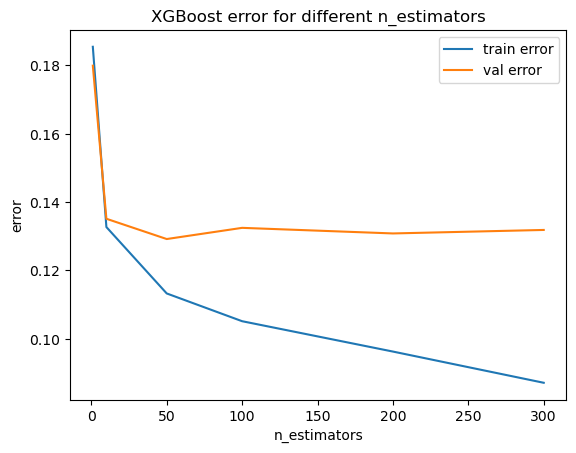

In [238]:
import xgboost as xgb

# number of trees to use in the ensemble
n_estimators = [1, 10, 50, 100,200,300]

train_errors = []
val_errors = []

for n in n_estimators: 

     xg = xgb.XGBClassifier(n_estimators=n, random_state=seed)

     xg.fit(X_train, y_train)

     # Compute the training  error rates
     train_err = (y_train!= xg.predict(X_train)).mean()
     train_errors.append(train_err)

     # Compute the validation error rates
     val_err = (y_val!= xg.predict(X_val)).mean()
     val_errors.append(val_err)

# Plot the resulting performance as a function of n estimate
plt.plot(n_estimators , train_errors,  label = 'train error');
plt.plot(n_estimators , val_errors,    label = 'val error');

plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('XGBoost error for different n_estimators')
plt.legend()
plt.show()

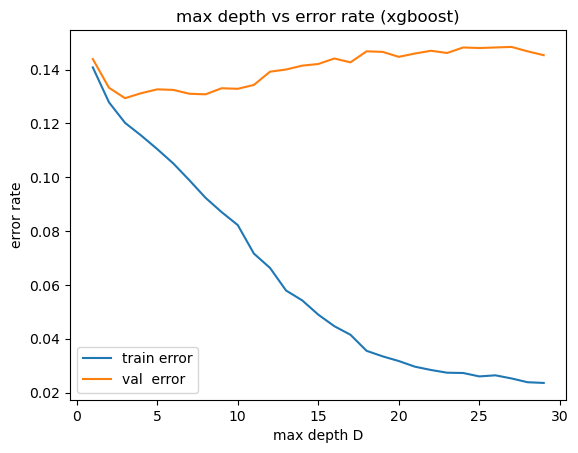

In [244]:
train_err_d = []
val_err_d = []

depth = list(range(1, 30))

for d in depth:
    learner = xgb.XGBClassifier(max_depth = d,
                      random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    train_err_d.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    val_err_d.append(val_err)

# Plot the resulting performance as a function of depth d
plt.plot(depth , train_err_d,  label = 'train error');
plt.plot(depth , val_err_d,    label = 'val  error');

plt.title("max depth vs error rate (xgboost)");
plt.xlabel("max depth D");
plt.ylabel("error rate");
plt.legend();

In [268]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': list(range(1, 15))}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Lambda:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Lambda: {'max_depth': 4}
Best Score: 0.874006780289383


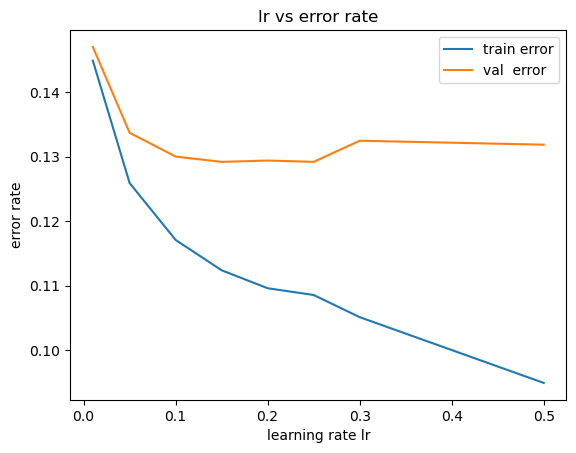

In [274]:
train_err_lr= []
val_err_lr = []

learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]

for lr in learning_rate:
    learner = xgb.XGBClassifier(learning_rate = lr,
                      random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    train_err_lr.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    val_err_lr.append(val_err)

# Plot the resulting performance as a function of depth d
plt.plot(learning_rate , train_err_lr,  label = 'train error');
plt.plot(learning_rate , val_err_lr,    label = 'val  error');

plt.title("lr vs error rate");
plt.xlabel("learning rate lr");
plt.ylabel("error rate");
plt.legend();

In [286]:
from sklearn.model_selection import GridSearchCV

param_grid = {'reg_lambda': [0.1, 1, 5, 10]}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Lambda:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Lambda: {'reg_lambda': 10}
Best Score: 0.8733203184151301


In [288]:
param_grid = {'reg_alpha': [0, 0.1, 1, 5]}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Alpha:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Alpha: {'reg_alpha': 0.1}
Best Score: 0.8725977097921269


In [2963]:
param_grid = {'gamma': [0, 0.1, 1, 5]}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Gamma:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Gamma: {'gamma': 1}
Best Score: 0.8730312096955266


In [292]:
param_grid = {
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.1, 1]
    #'gamma': [0, 0.1, 1]
}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'reg_alpha': 0, 'reg_lambda': 10}
Best Score: 0.8733203184151301


In [366]:
param_grid = {
    'n_estimators': [100],
    'max_depth' : [4] ,
    'learning_rate': [0.25], 
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.1, 1], 
    #'gamma': [0, 0.1, 1]
}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best Score: 0.8733564129475593


## optimal xgboost model

In [125]:
xgboost= xgb.XGBClassifier(
    max_depth =4,
    learning_rate = 0.25,    
    #gamma = 0,
    reg_alpha = 0.1,
    reg_lambda = 1,
    #n_estimators = 100,
    random_state=seed)

xgboost.fit(X_train, y_train)

# Compute the training  error rates
train_err = (y_train!= xgboost.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# Compute the validation error rates
val_err = (y_val!= xgboost.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# Compute the test error rates
test_err = (y_test!= xgboost.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)

cv_scores = cross_val_score(xgboost, X_train, y_train, cv=5, scoring='accuracy') 

print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")
print(f"Mean CV error: {1-cv_scores.mean()}")


Training error rate :  0.11750252926723515

validation error rate :  0.12835209825997954

test error rate :  0.1265892758430072

Cross-validation scores: [0.86127168 0.87895212 0.87804878 0.8767841  0.87172538]
Mean CV score: 0.8733564129475593
Mean CV error: 0.12664358705244072


# Ada Boost

## Base adaboost model

In [170]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')

base_estimator = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(estimator = base_estimator)
ada.fit(X_train, y_train)

# Compute the training  error rates
train_err = (y_train!= ada.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# Compute the validation error rates
val_err = (y_val!= ada.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# Compute the test error rates
test_err = (y_test!= ada.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.1383147853736089

validation error rate :  0.14104401228249744

test error rate :  0.13936490387568332


In [136]:
ada?

Type:        AdaBoostClassifier
String form:
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=10)
Length:      10
File:        /opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py
Docstring:  
An AdaBoost classifier.

An AdaBoost [1]_ classifier is a meta-estimator that begins by fitting a
classifier on the original dataset and then fits additional copies of the
classifier on the same dataset but where the weights of incorrectly
classified instances are adjusted such that subsequent classifiers focus
more on difficult cases.

This class implements the algorithm based on [2]_.

Read more in the :ref:`User Guide <adaboost>`.

.. versionadded:: 0.14

Parameters
----------
estimator : object, default=None
    The base estimator from which the boosted ensemble is built.
    Support for sample weighting is required, as well as proper
    ``classes_`` and ``n_classes_`` attributes. If ``None``, then
    the base esti

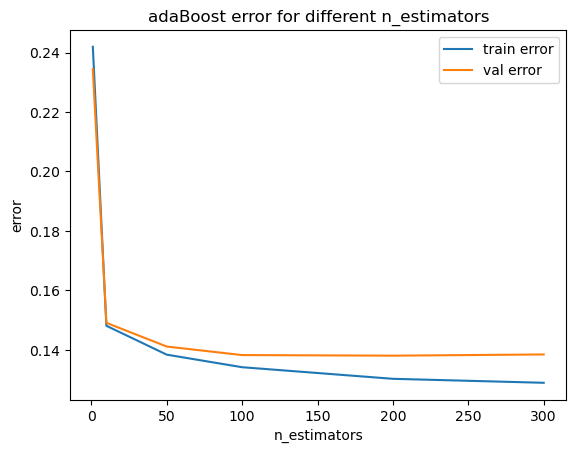

In [144]:
# number of trees to use in the ensemble
n_estimators = [1, 10, 50, 100,200,300]

train_errors = []
val_errors = []

for n in n_estimators: 

     ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=n)
     ada.fit(X_train, y_train)

     # Compute the training  error rates
     train_err = (y_train!= ada.predict(X_train)).mean()
     train_errors.append(train_err)

     # Compute the validation error rates
     val_err = (y_val!= ada.predict(X_val)).mean()
     val_errors.append(val_err)

# Plot the resulting performance as a function of n estimate
plt.plot(n_estimators , train_errors,  label = 'train error');
plt.plot(n_estimators , val_errors,    label = 'val error');

plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('adaBoost error for different n_estimators')
plt.legend()
plt.show()

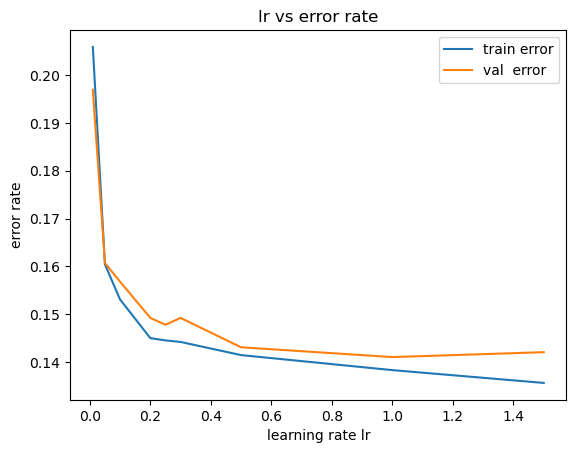

In [160]:
train_err_lr= []
val_err_lr = []

learning_rate = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 1.0, 1.5]

for lr in learning_rate:
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate = lr)
    
    ada.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= ada.predict(X_train)).mean()
    train_err_lr.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= ada.predict(X_val)).mean()
    val_err_lr.append(val_err)

# Plot the resulting performance as a function of depth d
plt.plot(learning_rate , train_err_lr,  label = 'train error');
plt.plot(learning_rate , val_err_lr,    label = 'val  error');

plt.title("lr vs error rate");
plt.xlabel("learning rate lr");
plt.ylabel("error rate");
plt.legend();


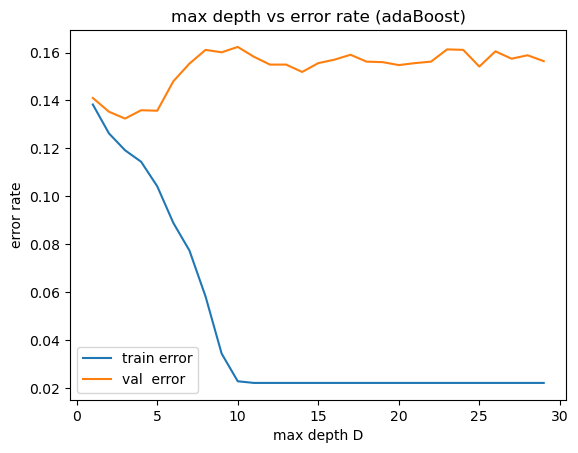

In [168]:
train_errors = []
val_errors = []

depth = list(range(1, 30))

for d in depth:
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d))
    
    ada.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= ada.predict(X_train)).mean()
    train_errors.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= ada.predict(X_val)).mean()
    val_errors.append(val_err)

# Plot the resulting performance as a function of depth d
plt.plot(depth , train_errors,  label = 'train error');
plt.plot(depth , val_errors,    label = 'val  error');

plt.title("max depth vs error rate (adaBoost)");
plt.xlabel("max depth D");
plt.ylabel("error rate");
plt.legend();

## optimal adaboost model

In [174]:
base_estimator = DecisionTreeClassifier(max_depth=5)
ada = AdaBoostClassifier(estimator = base_estimator, n_estimators=50, learning_rate = 0.5)
ada.fit(X_train, y_train)

# Compute the training  error rates
train_err = (y_train!= ada.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# Compute the validation error rates
val_err = (y_val!= ada.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# Compute the test error rates
test_err = (y_test!= ada.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.10687960687960688

validation error rate :  0.13613101330603888

test error rate :  0.13205577053006573


## comparing models (random forest & xgboost & adaBoost)

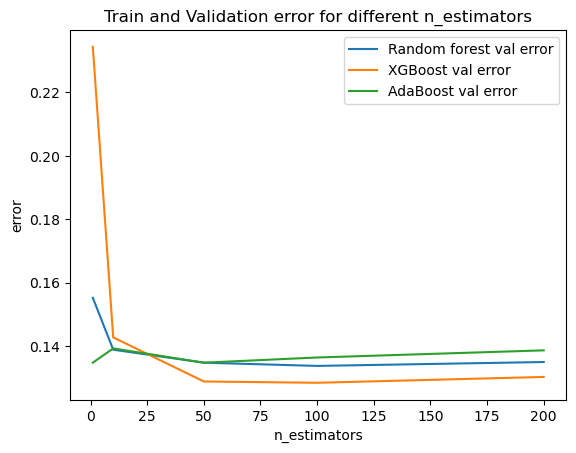

In [182]:
# number of trees to use in the ensemble
n_estimators = [1, 10, 50, 100,200]

rf_train_errors = []
rf_val_errors = []

xg_train_errors = []
xg_val_errors = []

ada_train_errors = []
ada_val_errors = []

for n in n_estimators: 
     RF =  RandomForestClassifier(random_state=seed, n_estimators = n, max_depth = 15, max_features = 0.5)
     RF.fit(X_train, y_train)

     xg=  xgb.XGBClassifier(max_depth =4, learning_rate = 0.25,  reg_alpha = 0.1, reg_lambda = 1, random_state=seed, n_estimators = n)
     xg.fit(X_train, y_train)

     ada = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=5), n_estimators=50, learning_rate = 0.5)
     ada.fit(X_train, y_train)

     # Compute the validation error rates
     val_err = (y_val!= RF.predict(X_val)).mean()
     rf_val_errors.append(val_err)

     # Compute the validation error rates
     val_err = (y_val!= xg.predict(X_val)).mean()
     xg_val_errors.append(val_err)

     # Compute the validation error rates
     val_err = (y_val!= ada.predict(X_val)).mean()
     ada_val_errors.append(val_err)

# Plot the resulting performance as a function of n estimate
plt.plot(n_estimators , rf_val_errors,     label = 'Random forest val error');
plt.plot(n_estimators , xg_val_errors,     label = 'XGBoost val error');
plt.plot(n_estimators , ada_val_errors,    label = 'AdaBoost val error');

plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('Train and Validation error for different n_estimators')
plt.legend()
plt.show()

# conclusion

Comparing our ensemble models, XGBoost had better performance than the Random Forest and adaboost for
both the baseline and optimal models, due to its ability to focus on misclassified samples
through boosting.This approach sequentially adjusts the model based on previous errors,
allowing XGBoost to refine predictions more effectively
and achieve better performance overall. 